# Quá trình tìm kiếm ảnh tương đồng

## import các thư viện và kết nối các file

In [1]:
pip install colormath

  Preparing metadata (setup.py) ... done
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39407 sha256=4fb4dc46762992011703c6d55d7220470e5ee8984e9889bad10c3b24ba19c59f
  Stored in directory: /root/.cache/pip/wheels/ab/b3/4d/c0738759c25a1df01958068f162cf2a9dc3ab1da8b972cfcfc
Successfully built colormath


In [2]:
import dlib
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
import os
from math import sqrt
from math import acos
import pandas as pd
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

In [3]:
#kết nối google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# địa chỉ path
path_haarcascade = "/content/gdrive/MyDrive/DPT/assets/haarcascade.xml"
path_faciallandmark = "/content/gdrive/MyDrive/DPT/assets/shape_predictor_68_face_landmarks.dat"

In [5]:
predict_68 = dlib.shape_predictor(path_faciallandmark)
detector = dlib.get_frontal_face_detector()

In [6]:
data_dir = "/content/gdrive/MyDrive/DPT/dataset"
test_dir = "/content/gdrive/MyDrive/DPT/test"

## def

In [7]:
#tìm kiếm khuân mặt
def face_detection(img):
  faces = detector(img, 0)
  if len(faces) > 0:
    return img[faces[0].top():faces[0].bottom(), faces[0].left():faces[0].right()]
  else:
    return img

  # trích vùng màu da
def extract_skin(img):
  img_HSV = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  HSV_mask = cv.inRange(img_HSV, (0, 15, 0), (17,170,255))
  HSV_mask = cv.morphologyEx(HSV_mask, cv.MORPH_OPEN, np.ones((3,3), np.uint8))

  img_YCrCb = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)
  YCrCb_mask = cv.inRange(img_YCrCb, (0, 135, 85), (255,180,135))
  YCrCb_mask = cv.morphologyEx(YCrCb_mask, cv.MORPH_OPEN, np.ones((3,3), np.uint8))

  global_mask=cv.bitwise_and(YCrCb_mask,HSV_mask)
  global_mask=cv.GaussianBlur(global_mask,(3,3),0)

  skin  =  cv.bitwise_and(img,img,mask=global_mask)
  return skin

# xóa các mảng đen không phải màu da
def removeBlack(estimator_labels, estimator_cluster):
  hasBlack = False
  # Lấy tổng số lần xuất hiện của mỗi màu
  occurance_counter = Counter(estimator_labels)

  compare = lambda x, y: Counter(x) == Counter(y)
  black_threshold = 20
  mask = np.all(estimator_cluster <= black_threshold,axis=1)
  estimator_cluster = estimator_cluster[~mask]
  for i in range(len(mask)):
    if mask[i] :
      del occurance_counter[i]
  hasBlack = True

  return (occurance_counter,estimator_cluster,hasBlack)

#lấy thông tin màu da
def getColorInformation(estimator_labels, estimator_cluster,hasThresholding=False):

  occurance_counter = None

  colorInformation = []

  #Check for Black
  hasBlack =False

  if hasThresholding == True:

    (occurance,cluster,black) = removeBlack(estimator_labels,estimator_cluster)
    occurance_counter =  occurance
    estimator_cluster = cluster
    hasBlack = black

  else:
    occurance_counter = Counter(estimator_labels)

  # tổng mẫu dự đoán
  totalOccurance = sum(occurance_counter.values())

  # Lặp lại tất cả các màu được dự đoán
  for x in occurance_counter.most_common(len(estimator_cluster)):

    index = (int(x[0]))

    # sửa chỉ mục nếu có xóa màu đen
    index =  (index-1) if ((hasThresholding & hasBlack)& (int(index) !=0)) else index

    # chỉ số màu sách rgb
    color = estimator_cluster[index].tolist()

    # phần trăm của màu sắc
    color_percentage= (x[1]/totalOccurance)

    #thông tin màu sắc
    colorInfo = {"cluster_index":index , "color": color , "color_percentage" : color_percentage }

    colorInformation.append(colorInfo)

  return colorInformation

  #trích các màu sắc chủ đạo của da
def extractDominantColor(image,number_of_colors,hasThresholding=False):

  # tăng 1 cụm dành cho màu đen
  if hasThresholding == True:
    number_of_colors +=1

  img = image.copy()

  # Convert Image into RGB Colours Space
  img = cv.cvtColor(img,cv.COLOR_BGR2RGB)

  # Reshape Image
  img = img.reshape((img.shape[0]*img.shape[1]) , 3)

  #Initiate KMeans Object
  estimator = KMeans(n_clusters=number_of_colors, random_state=0)

  # Fit the image
  estimator.fit(img)

  print(estimator.cluster_centers_)
  # Get Colour Information
  colorInformation = getColorInformation(estimator.labels_,estimator.cluster_centers_,hasThresholding)
  return colorInformation


In [8]:
def face_points(img):
  img2 = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
  faces = detector(img, 0)
  for face in faces:
    landmarks = predict_68(img, face)
    #mui
    mui_x = landmarks.part(30).x
    mui_y = landmarks.part(30).y
    #mat trai ngoai
    mat_trai_ngoai_x = landmarks.part(36).x
    mat_trai_ngoai_y = landmarks.part(36).y
    #mat trai trong
    mat_trai_trong_x = landmarks.part(39).x
    mat_trai_trong_y = landmarks.part(39).y
    #mat phai trong
    mat_phai_trong_x = landmarks.part(42).x
    mat_phai_trong_y = landmarks.part(42).y
    #mat phai ngoai
    mat_phai_ngoai_x = landmarks.part(45).x
    mat_phai_ngoai_y = landmarks.part(45).y
    #moi trai
    moi_trai_x = landmarks.part(48).x
    moi_trai_y = landmarks.part(48).y
    #moi phai
    moi_phai_x = landmarks.part(54).x
    moi_phai_y = landmarks.part(54).y

    pointInfo = {"mui_x":mui_x , "mui_y": mui_y ,
                 "mat_trai_ngoai_x" : mat_trai_ngoai_x, "mat_trai_ngoai_y" : mat_trai_ngoai_y,
                 "mat_trai_trong_x" : mat_trai_trong_x, "mat_trai_trong_y" : mat_trai_trong_y,
                 "mat_phai_trong_x" : mat_phai_trong_x, "mat_phai_trong_y" : mat_phai_trong_y,
                 "mat_phai_ngoai_x" : mat_phai_ngoai_x, "mat_phai_ngoai_y" : mat_phai_ngoai_y,
                 "moi_trai_x" : moi_trai_x, "moi_trai_y" : moi_trai_y,
                 "moi_phai_x" : moi_phai_x, "moi_phai_y" : moi_phai_y  }
  return pointInfo
def caculate_triangle(a,b,c):
  s = (a+b+c)/2
  area = sqrt(s*(s-a)*(s-b)*(s-c))
  a1 = acos((b*b+c*c-a*a)/(2*b*c))
  a2 = acos((a*a+c*c-b*b)/(2*a*c))
  a3 = acos((a*a+b*b-c*c)/(2*a*b))
  return area,a1,a2,a3
def caculate_points(img):
  pointInfo = face_points(img)
  mui_x = pointInfo["mui_x"]
  mui_y = pointInfo["mui_y"]
  mat_trai_ngoai_x = pointInfo["mat_trai_ngoai_x"]
  mat_trai_ngoai_y = pointInfo["mat_trai_ngoai_y"]
  mat_trai_trong_x = pointInfo["mat_trai_trong_x"]
  mat_trai_trong_y = pointInfo["mat_trai_trong_y"]
  mat_phai_trong_x = pointInfo["mat_phai_trong_x"]
  mat_phai_trong_y = pointInfo["mat_phai_trong_y"]
  mat_phai_ngoai_x = pointInfo["mat_phai_ngoai_x"]
  mat_phai_ngoai_y = pointInfo["mat_phai_ngoai_y"]
  moi_trai_x = pointInfo["moi_trai_x"]
  moi_trai_y = pointInfo["moi_trai_y"]
  moi_phai_x = pointInfo["moi_phai_x"]
  moi_phai_y = pointInfo["moi_phai_y"]

  #a1-a2
  d1 = sqrt(pow(mat_trai_trong_x - mat_trai_ngoai_x,2) + pow(mat_trai_trong_y - mat_trai_ngoai_y,2))
  #a1-a3, a13-a14
  d2 = sqrt(pow(mat_trai_ngoai_x - mui_x,2) + pow(mat_trai_ngoai_y - mui_y,2))
  #a2-a3,a4-a6
  d3 = sqrt(pow(mat_trai_trong_x - mui_x,2) + pow(mat_trai_trong_y - mui_y,2))
  #a4-a5
  d4 = sqrt(pow(mat_trai_trong_x - mat_phai_trong_x,2) + pow(mat_trai_trong_y - mat_phai_trong_y,2))
  #a5-a6, a7-a9
  d5 = sqrt(pow(mat_phai_trong_x - mui_x,2) + pow(mat_phai_trong_y - mui_y,2))
  #a7-a8
  d6 = sqrt(pow(mat_phai_trong_x - mat_phai_ngoai_x,2) + pow(mat_phai_trong_y - mat_phai_ngoai_y,2))
  #a8-a9, a10-a11
  d7 = sqrt(pow(mat_phai_ngoai_x - mui_x,2) + pow(mat_phai_ngoai_y - mui_y,2))
  #a10-a12
  d8 = sqrt(pow(mat_phai_ngoai_x - moi_phai_x,2) + pow(mat_phai_ngoai_y - moi_phai_y,2))
  #a11-a12,a16-a18
  d9 = sqrt(pow(moi_phai_x - mui_x,2) + pow(moi_phai_y - mui_y,2))
  #a17-a18
  d10 = sqrt(pow(moi_phai_x - moi_trai_x,2) + pow(moi_phai_y - moi_trai_y,2))
  #a16-a17,a14-a15
  d11 = sqrt(pow(moi_trai_x - mui_x,2) + pow(moi_trai_y - mui_y,2))
  #a13-a15
  d12 = sqrt(pow(moi_trai_x - mat_trai_ngoai_x,2) + pow(moi_trai_y - mat_trai_ngoai_y,2))

  A1, a1, a2, a3 = caculate_triangle(d3,d2,d1)
  A2, a4, a5, a6 = caculate_triangle(d5,d3,d4)
  A3, a7, a8, a9 = caculate_triangle(d7,d5,d6)
  A5, a10, a11, a12 = caculate_triangle(d9,d8,d7)
  A4, a13, a14, a15 = caculate_triangle(d11,d12,d2)
  A6, a16, a17, a18 = caculate_triangle(d10,d9,d11)
  return [A1,A2,A3,A4,A5,A6,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18]

In [9]:
def patch_asscalar(a):
    return a.item()

setattr(np, "asscalar", patch_asscalar)

In [10]:
def normalize(delta):
  delta_min = np.min(delta)
  delta_max = np.max(delta)
  return [(d - delta_min)/(delta_max - delta_min) for d in delta]

## trích đặc trưng ảnh test

In [11]:
def extract_test(filename):
  img_test = cv.imread(os.path.join(test_dir, filename))
  face_img = face_detection(img_test)
  extract_img = extract_skin(face_img)
  dominantColors = extractDominantColor(extract_img,number_of_colors=2 ,hasThresholding=True)
  feature_colorskin = dominantColors[0]["color"]
  feature_points = caculate_points(img_test)
  feature_points_2 = feature_points.copy()

  for i in range(6):
    feature_points_2[i] = feature_points[i]/feature_points[(i+1)%6]
  feature_test = feature_colorskin + feature_points_2
  feature_test = np.array(feature_test)
  return feature_test, img_test

## so sánh độ sai số và tìm ảnh giống nhất

In [12]:
def get_nearest_image(feature_path, feature_test):
  df = pd.read_csv(feature_path)
  arr = df.to_numpy()
  delta_color = []
  #màu của ảnh thử nghiệm
  test_color = convert_color(sRGBColor(feature_test[0], feature_test[1],feature_test[2], is_upscaled= True), LabColor)

  for i in range(len(arr)):
    feature_color =convert_color(sRGBColor(arr[i][1],arr[i][2],arr[i][3], is_upscaled=True), LabColor)
    delta_color.append(delta_e_cie2000(feature_color,test_color))
  delta_points = np.linalg.norm(arr[:,4:].astype(float) - feature_test[3:].astype(float), axis=1)
  delta_points_n = normalize(delta_points)
  delta_color_n = normalize(delta_color)
  delta = np.mean(np.array([delta_color_n,delta_points_n]),axis=0)
  ids = np.argsort(delta)
  nearest_image = [(arr[i][0], delta[i]) for i in ids]
  return nearest_image

## đưa ra kết quả

In [13]:
def main(filename, feature_path):
  feature_test, img_test = extract_test(filename)
  print(feature_test)
  nearest_image = get_nearest_image(feature_path, feature_test)
  fig, (ax1,ax2) = plt.subplots(2,3, figsize=(12,8))
  ax1[0].set_visible(False)
  ax1[2].set_visible(False)
  ax1[1].imshow(cv.cvtColor(img_test, cv.COLOR_BGR2RGB))
  ax1[1].set_title('Ảnh test')

  ax2[0].imshow(cv.cvtColor(cv.imread(os.path.join(data_dir, nearest_image[0][0])), cv.COLOR_BGR2RGB))
  ax2[0].set_title('Ảnh 1')
  ax2[0].set_xlabel('sai số:'+str(round(nearest_image[0][1],3)))

  ax2[1].imshow(cv.cvtColor(cv.imread(os.path.join(data_dir, nearest_image[1][0])), cv.COLOR_BGR2RGB))
  ax2[1].set_title('Ảnh 2')
  ax2[1].set_xlabel('sai số:'+str(round(nearest_image[1][1],3)))

  ax2[2].imshow(cv.cvtColor(cv.imread(os.path.join(data_dir, nearest_image[2][0])), cv.COLOR_BGR2RGB))
  ax2[2].set_title('Ảnh 3')
  ax2[2].set_xlabel('sai số:'+str(round(nearest_image[2][1],3)))

  plt.subplots_adjust(wspace=0.2, hspace=0.2)

  plt.show()
  return img_test, nearest_image

In [14]:
filename = "image_059.jpg"

In [15]:
feature_path = '/content/gdrive/MyDrive/DPT/features.csv'

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[ 14.20929119   8.60715996   6.48591156]
 [221.86263331 190.84933747 164.67447482]
 [188.6964747  148.40573366 121.28038024]]
[221.86263331 190.84933747 164.67447482   0.52959831   1.90225564
   0.30101584   1.02506137   1.45539851   2.21036188   0.50433689
   2.312378     0.32487776   0.94919171   0.97681463   1.21558632
   2.29238022   0.51395349   0.33525894   0.62594131   1.52195339
   0.99369796   0.61591234   1.53394266   0.99173766   1.35156624
   0.89142822   0.8985982 ]


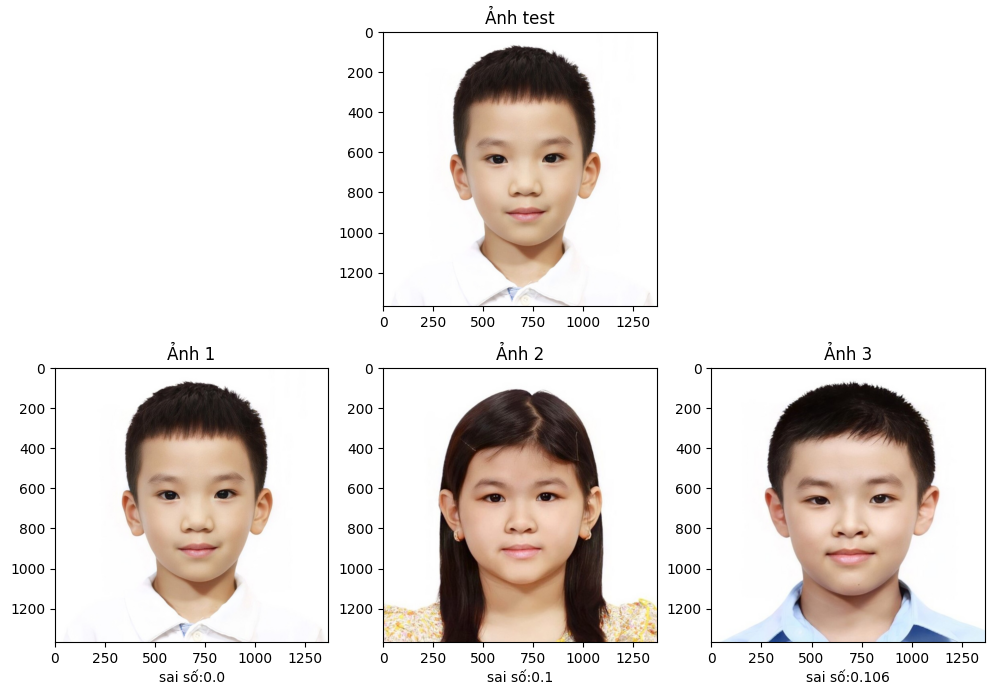

In [16]:
img_test, nearest_image= main(filename,feature_path)

In [ ]:
filename2 = "image_055.jpg"

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[184.42757964 136.34265147 122.15251027]
 [  5.30958231   3.38055946   3.11998581]
 [228.41096327 181.08555513 165.86484253]]
[228.41096327 181.08555513 165.86484253   0.63089766   1.66552101
   0.29589054   1.00171328   1.3291482    2.41570027   0.51931085
   2.24926118   0.37302063   1.01126167   1.00482008   1.12551091
   2.26385732   0.52102699   0.35670834   0.67979616   1.49624499
   0.9655515    0.66881869   1.49784324   0.97493073   1.4338572
   0.85919234   0.84854312]


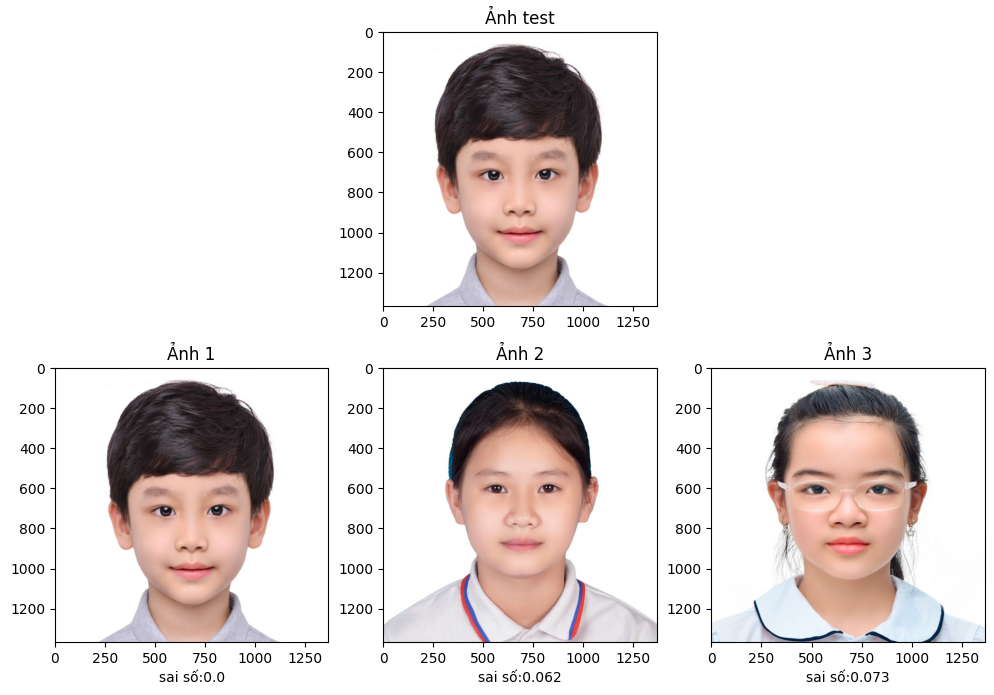

In [ ]:
img_test2, nearest_image2 = main(filename2,feature_path)

In [ ]:
filename4 = "test2.jpg"

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[226.53207854 172.31622308 158.92970875]
 [ 13.82560871   9.50978481   7.81639791]
 [181.05789056 127.38862807 111.67892149]]
[226.53207854 172.31622308 158.92970875   0.58947071   1.7398001
   0.28235675   1.05185167   1.34053102   2.44911328   0.48548839
   2.31079394   0.34531032   0.93995075   0.98525366   1.21638824
   2.29248442   0.4916728    0.35743543   0.66321627   1.50107643
   0.97729995   0.66198723   1.50028951   0.97931591   1.36268537
   0.87475689   0.9041504 ]


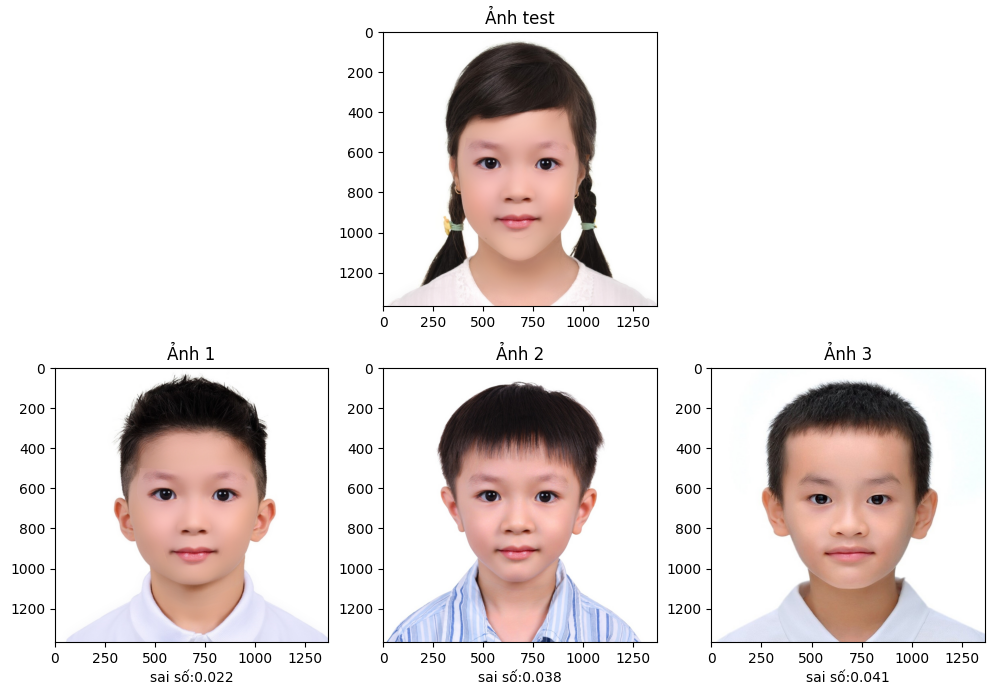

In [ ]:
img_test4, nearest_image4 = main(filename4,feature_path)

In [ ]:
filename3 = "test.jpg"

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[200.36274083 146.19247668 124.71206404]
 [  9.55073812   5.13459749   4.18167643]
 [229.46382426 181.00533796 162.77328236]]
[229.46382426 181.00533796 162.77328236   0.68989763   1.49856667
   0.23626213   1.04679237   1.31429435   2.97571942   0.42989478
   2.32973913   0.38195875   0.87998656   0.92302399   1.3385821
   2.31566526   0.4326687    0.39325869   0.71068441   1.60098567
   0.82992258   0.72325188   1.5626691    0.85567168   1.005731
   1.05121909   1.08464256]


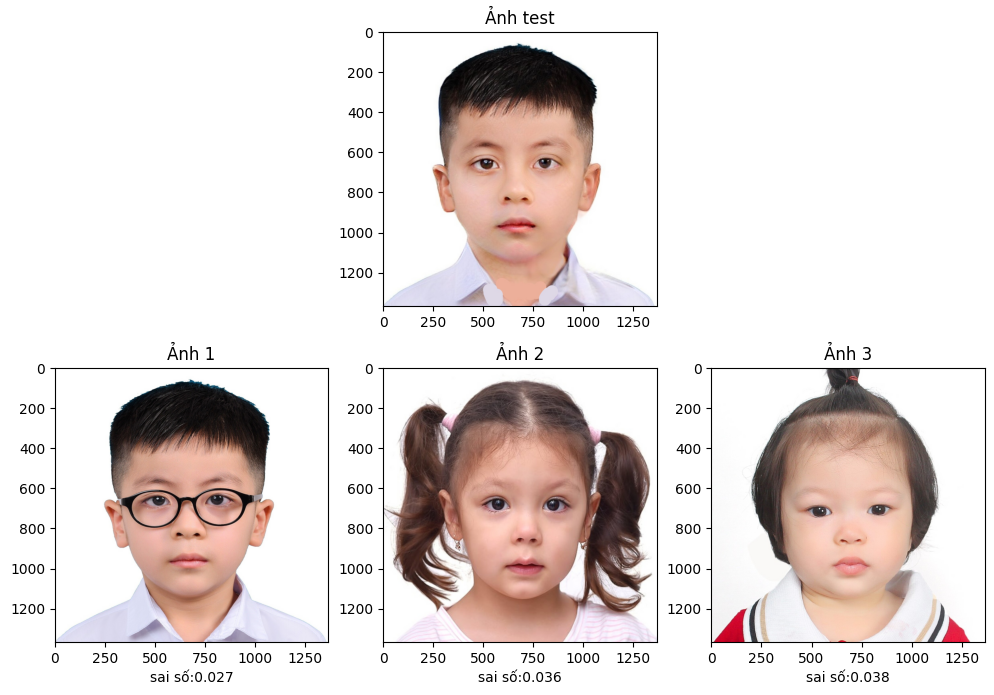

In [ ]:
img_test3, nearest_image3 = main(filename3,feature_path)

In [ ]:
filename5 = "13.1.jpg"

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[220.90059449 179.3203964  159.97655301]
 [  5.45018019   2.98850687   2.21788254]
 [197.78453169 150.39123025 128.51689061]]
[220.90059449 179.3203964  159.97655301   0.65062788   1.51475155
   0.23871192   1.04424715   1.43453063   2.83751846   0.37790872
   2.42144916   0.34223478   0.8462257    0.92149794   1.37386901
   2.33387455   0.4141637    0.3935544    0.68280821   1.63284161
   0.82594284   0.67263324   1.57322885   0.89573057   0.96745665
   1.10195666   1.07217935]


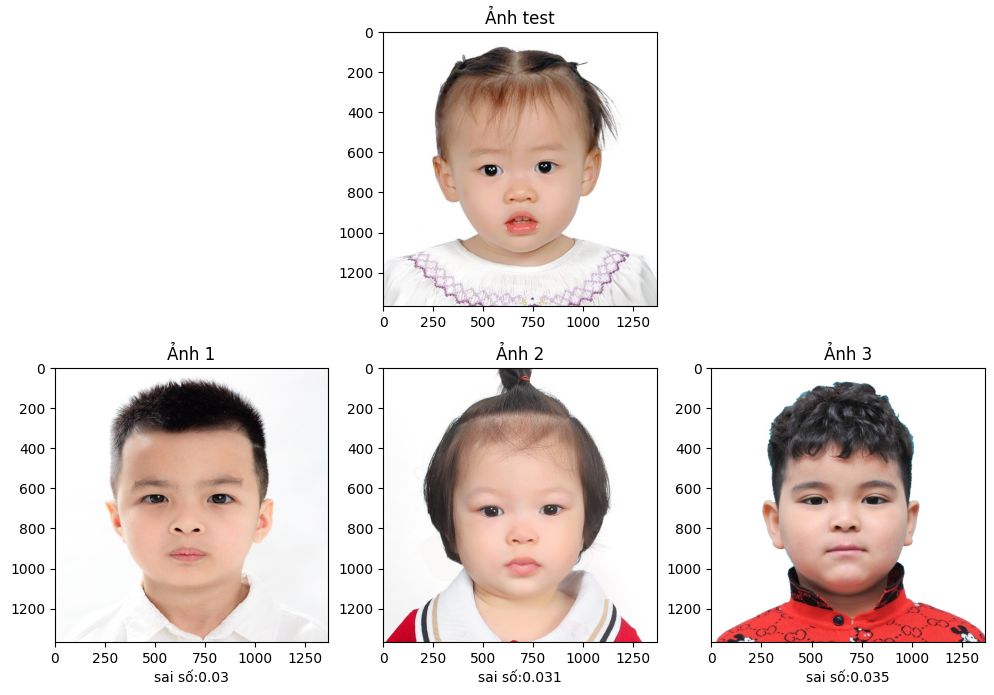

In [ ]:
img_test5, nearest_image5 = main(filename5,feature_path)